In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import numpy as np
import pandas as pd

amount_path = "./dataset/amount.csv"
count_path = "./dataset/count.csv"
percent_path = "./dataset/percent.csv"

In [ ]:
def files_from_args(): 
    import argparse
    parser = argparse.ArgumentParser() 
    parser.add_argument('-f', '--file', default='file')
    parser.add_argument('-c', '--column', default='column') 
    parser.add_argument('-o', '--output',default='output') 

    args = parser.parse_args() 
    return (args.file, args.column, args.output) 

In [ ]:
def gradandcleanthedata(file_path,header_path,cols,donation_transaction_list):
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.getOrCreate()
    
    reader = spark.read 
    reader.option("header",False) 
    reader.option("inferSchema",True) 
    reader.option("sep", "|") 
    donation_df = reader.csv(file_path)

    reader = spark.read 
    reader.option("header",True) 
    reader.option("inferSchema",True) 
    reader.option("delimter", "|") 
    header_df = reader.csv(header_path)
    donation_df =  donation_df.toDF(*header_df.columns)
    donation_df = donation_df.select(cols)
    donation_df = donation_df[donation_df.TRANSACTION_TP.isin( donation_transaction_list)]
    return donation_df

In [ ]:
if __name__ == "__main__": 
    columns_need =["CMTE_ID","TRANSACTION_TP","ENTITY_TP","TRANSACTION_AMT","NAME"]    
    donation_transaction_list =["15","15E","17R","18K","18L","18U","19"]    
    
    file_path, heaher_path,output = files_from_args() 
    donation_df = gradandcleanthedata(file_path,heaher_path,columns_need,donation_transaction_list)
    
    count_donation(donation_df,output)  
    amount_donation(donation_df,output)
    percentage_donation(donation_df,output)    
    data_for_histogram_donation(donation_df,output)    

# Question 1
# 1. How many donations did each campaign have?

In [ ]:
def count_donation(donation_df,output):
    import pyspark.sql.functions as sparkfun
    three_cand_count = donation_df.groupBy('CMTE_ID').agg( sparkfun.count('CMTE_ID'))
    result_1 = three_cand_count[three_cand_count.CMTE_ID.isin(["C00575795","C00577130","C00580100"])]
    print("The count of donations for each campaign")
    result_1.show()
    result_1 = result_1.repartition(1)
    count_output = output + "-count"
    result_1.write.format('csv').option("header", "true").save(count_output)   

In [234]:
reader = spark.read 
reader.option("header",True) 
reader.option("inferSchema",True) 
count_df = reader.csv(count_path)
count_df.show()

+---------+--------------+
|  CMTE_ID|count(CMTE_ID)|
+---------+--------------+
|C00577130|       1516865|
|C00580100|        133102|
|C00575795|       2484186|
+---------+--------------+



# 2. What was the total amount donated to each campaign?

In [ ]:
def amount_donation(donation_df,output):
    import pyspark.sql.functions as sparkfun
    three_cand_amt = donation_df.groupBy('CMTE_ID')\
    .agg( sparkfun.sum('TRANSACTION_AMT') )
    result_2 = three_cand_amt[three_cand_amt.CMTE_ID.isin(["C00575795","C00577130","C00580100"])]
    
    print("The amount of donations for each campaign")
    result_2.show()
    result_2 = result_2.repartition(1)
    amount_output = output + "-amount"
    result_2.write.format('csv').option("header", "true").save(amount_output)

In [235]:
reader = spark.read 
reader.option("header",True) 
reader.option("inferSchema",True) 
amount_df = reader.csv(amount_path)
amount_df.show()

+---------+--------------------+
|  CMTE_ID|sum(TRANSACTION_AMT)|
+---------+--------------------+
|C00577130|            79300233|
|C00580100|            44608876|
|C00575795|           286783401|
+---------+--------------------+



# 3. What percentage of the each campaign’s donations was done by small contributors?

In [ ]:
def percentage_donation(donation_df,output):
    import pyspark.sql.functions as sparkfun
    
    three_cand_amt = donation_df.groupBy("CMTE_ID", "NAME")\
        .agg( sparkfun.sum('TRANSACTION_AMT').alias("SUM") )\
        .where(((sparkfun.col("CMTE_ID") == "C00575795") \
                | (sparkfun.col("CMTE_ID") == "C00577130") \
                | (sparkfun.col("CMTE_ID") == "C00580100")) )

    three_cand_count = three_cand_amt.where(sparkfun.col("SUM")>=0).groupBy("CMTE_ID")\
            .agg( sparkfun.count('NAME').alias("All") )

    three_cand_small_count = three_cand_amt.where(sparkfun.col("SUM").between(0,200))\
        .groupBy("CMTE_ID").agg( sparkfun.count('NAME').alias("Small"))
    
    result_3 =  three_cand_count.join(three_cand_small_count, on=["CMTE_ID"])
    result_3 = result_3.withColumn('Percentage',result_3["Small"]/result_3["All"] )
    
    print("The percentage of small contributors each campaign")
    result_3.show()
    result_3 = result_3.repartition(1)
    percent_output = output + "-percent"
    result_3.write.format('csv').option("header", "true").save(percent_output)

In [240]:
reader = spark.read 
reader.option("header",True) 
reader.option("inferSchema",True) 
percent_df = reader.csv(percent_path)
percent_df.show()

+---------+------+------+-------------------+
|  CMTE_ID|   All| Small|         Percentage|
+---------+------+------+-------------------+
|C00577130|222844|121484| 0.5451526628493475|
|C00580100| 76945| 17718|0.23026837351354865|
|C00575795|377245|142882| 0.3787512094262349|
+---------+------+------+-------------------+



# 4. Produce a histogram of the donations for each campaign?

In [ ]:
def data_for_histogram_donation(donation_df,output):
    
    three_cand_amt = donation_df.groupBy("CMTE_ID", "NAME")\
        .agg( sparkfun.sum('TRANSACTION_AMT').alias("SUM") )\
        .where(((sparkfun.col("CMTE_ID") == "C00575795") \
                | (sparkfun.col("CMTE_ID") == "C00577130") \
                | (sparkfun.col("CMTE_ID") == "C00580100")) )\
        .where(sparkfun.col("SUM") >=0)
    
    hillary_df = three_cand_amt.where(three_cand_amt["CMTE_ID"] == "C00575795")
    bernie_df = three_cand_amt.where(three_cand_amt["CMTE_ID"] == "C00577130")    
    trump_df = three_cand_amt.where(three_cand_amt["CMTE_ID"] == "C00580100")
    
    print("hllary_df")
    hillary_df.show()
    
    print("bernie_df")
    bernie_df.show()
    
    print("trump_df")
    trump_df.show()

    hillary_df = hillary_df.repartition(1)
    hillary_output = output + "-hillary"
    hillary_df.write.format('csv').option("header", "true").save(hillary_output)  
    
    bernie_df = bernie_df.repartition(1)
    bernie_output = output + "-bernie"
    bernie_df.write.format('csv').option("header", "true").save(bernie_output)  
    
    trump_df = trump_df.repartition(1)
    trump_output = output + "-trump"
    trump_df.write.format('csv').option("header", "true").save(trump_output)  

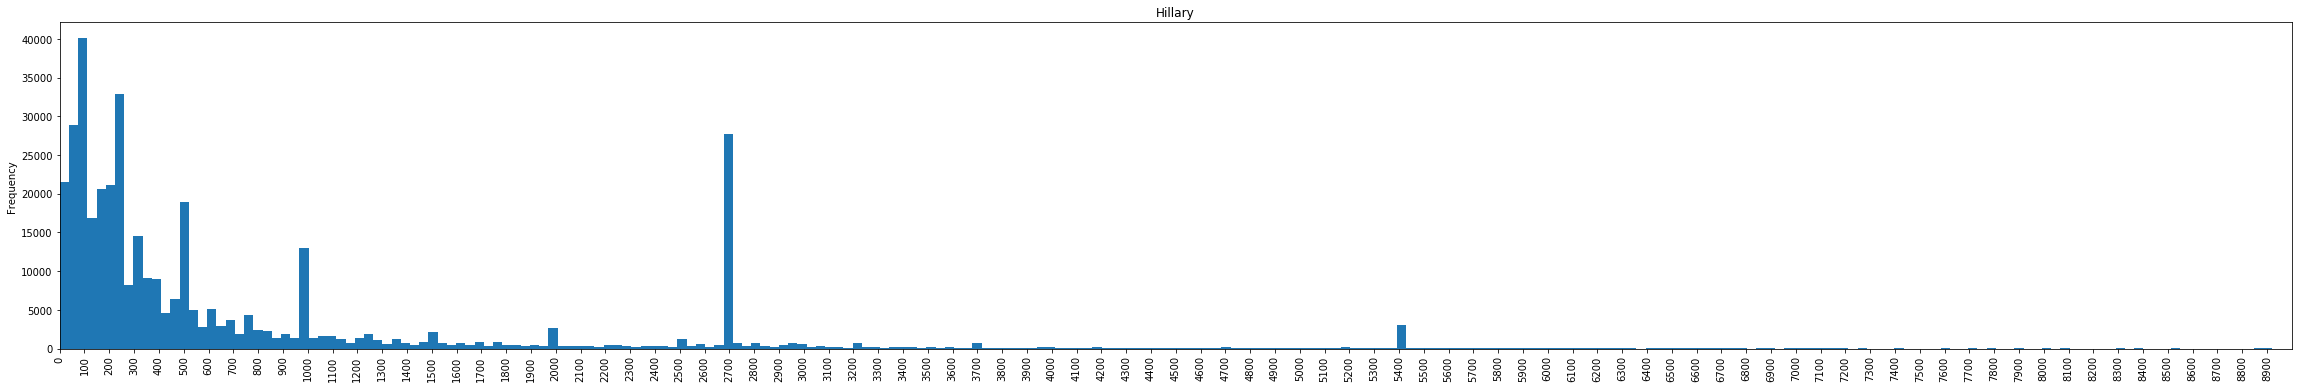

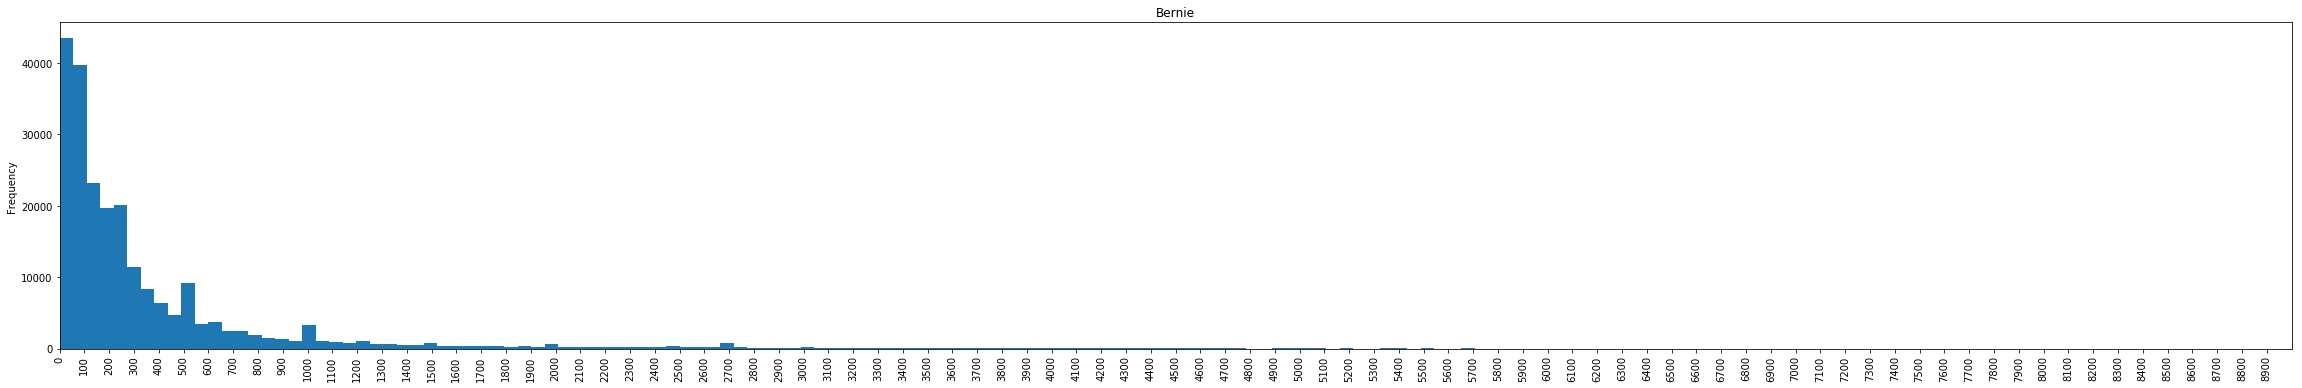

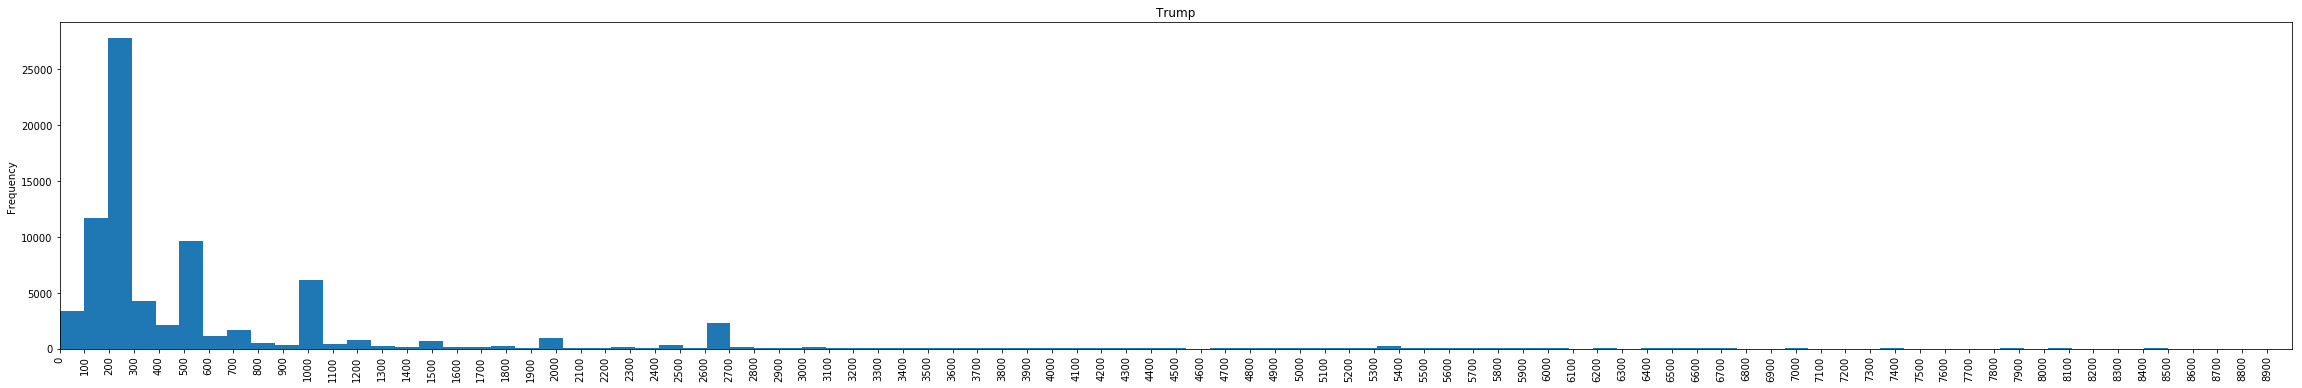

In [286]:
hillary_path = "./dataset/hillary.csv"
bernie_path = "./dataset/bernie.csv"
trump_path = "./dataset/trump.csv"

hillary_df = pd.read_csv(hillary_path,usecols =["SUM"])
bernie_df = pd.read_csv(bernie_path,usecols =["SUM"])
trump_df = pd.read_csv(trump_path)


ax = hillary_df.plot.hist(title= "Hillary" ,bins = 900, legend = False, figsize=(40,6),rot=90,xlim= [0,9000])
_ = ax.set_xticks(np.arange(0,9000,step=100))

ax = bernie_df.plot.hist(title= "Bernie" ,bins = 900, legend = False, figsize=(40,6),rot=90,xlim= [0,9000])
_ = ax.set_xticks(np.arange(0,9000,step=100))

ax = trump_df.plot.hist(title= "Trump" ,bins = 900, legend = False, figsize=(40,6),rot=90,xlim= [0,9000])
_ = ax.set_xticks(np.arange(0,9000,step=100))

# AWS CLI

aws emr create-cluster --applications Name=Ganglia Name=Spark Name=Zeppelin --ec2-attributes '{"InstanceProfile":"EMR_EC2_DefaultRole","SubnetId":"subnet-e3b9baa9","EmrManagedSlaveSecurityGroup":"sg-04d7d8034174449a3","EmrManagedMasterSecurityGroup":"sg-06fc1c2f29678d385"}' --service-role EMR_DefaultRole --enable-debugging --release-label emr-5.23.0 --log-uri 's3n://aws-logs-776025538154-us-east-1/elasticmapreduce/' --steps '[{"Args":["spark-submit","--deploy-mode","client","s3://cs696assignment4/Assignment4.py","-c","s3://cs696assignment4/indiv_header_file.csv","-f","s3://rw-cs696-data/itcont.txt","-o","s3://my-aws-output/assignment4run2"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Assignment4"}]' --name 'CS696Assignment4' --instance-groups '[{"InstanceCount":1,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":1}]},"InstanceGroupType":"MASTER","InstanceType":"m4.large","Name":"Master Instance Group"},{"InstanceCount":2,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":1}]},"InstanceGroupType":"CORE","InstanceType":"m4.large","Name":"Core Instance Group"}]' --configurations '[{"Classification":"spark","Properties":{}}]' --scale-down-behavior TERMINATE_AT_TASK_COMPLETION --region us-east-1
